# Basic Config

In [31]:
params = {
    # TODO: Modify weight each experiment
#     "weight": "./exp/0405_unDt_15/model",
    "weight": "./exp/0409triplet_test/model",
    
    "D_2400": "/home/ubuntu/dataset/D_2400/",
    "Dst_300": "/home/ubuntu/dataset/DsDt_test300",
    "Dst_100": "/home/ubuntu/dataset/test_100",
    "config": {
        "num_class": 19,
        "size": [224,224],
        "batch_size": 64,
    },
}

# Export Embedding
- test 300
- test 100
- train 2400

### Import Libraries

In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #supress tensorflow info except error
gpuNum = 0

import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[gpuNum], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpuNum], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

from model.input_fn_dict import dataset_pipeline
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tqdm import tqdm

4 Physical GPUs, 1 Logical GPU


### Dataset function

In [33]:
def parse_filename(path):
    ds_root = pathlib.Path(path)
    filenames = list(ds_root.glob('*/*'))
    filenames = [str(path) for path in filenames]
    random.shuffle(filenames)
    label_names = sorted(item.name for item in ds_root.glob('*/')
            if item.is_dir())
    label_to_index = dict((name, index) for index, name
            in enumerate(label_names))
    labels = [label_to_index[pathlib.Path(path).parent.name]
            for path in filenames]
    return filenames, labels, len(filenames)

def _parse_function(data, size):
    filename = data['img']
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3, dct_method='INTEGER_ACCURATE')
    image = tf.cast(image, tf.float32)
    image = ((image / 255.0)-0.5)*2.0
    image = tf.image.resize(image, size)
    data['img'] = image
    return data

def generate_dataset(filenames, labels, params):
    parse_fn = lambda d: _parse_function(d, params["size"])
    
    dataset = tf.data.Dataset.from_tensor_slices({'img':filenames, 'label':labels})
    dataset = dataset.shuffle(len(filenames))
    dataset = dataset.map(parse_fn, num_parallel_calls=4)
    return dataset

def dataset_pipeline(folder, params, val=False):
    if val:
        test_filenames, test_labels, test_counts = parse_filename(folder)
        test_ds = generate_dataset(test_filenames, test_labels, params)
        return test_ds, test_counts
    train_filenames, train_labels, train_counts = parse_filename(folder)
    train_ds = generate_dataset(train_filenames, train_labels)
    return train_ds, train_counts

### Prepare and load Model

In [34]:
baseModel = MobileNetV2(
    include_top=False, weights=None,
    input_shape=(224, 224, 3), pooling="avg")

fc = tf.keras.layers.Dense(
    128, activation=None, name="embeddings")(baseModel.output) 

l2 = tf.math.l2_normalize(fc)
model = Model(inputs=baseModel.input, outputs=l2)

model.load_weights(params["weight"])

### Export test 300

In [35]:
test_ds, _ = dataset_pipeline(params["Dst_300"], params["config"], val=True)

vecs = np.empty((0,128),np.float)
metas = np.empty((0),np.float)

for cls in tqdm(range(params['config']['num_class'])):
    ds = test_ds.filter(lambda data: data['label'] == cls)
    ds = ds.batch(params['config']['batch_size'])
    for data in ds:
        feat = model.predict(data['img'])
        vecs = np.append(vecs, feat, axis=0)
        metas = np.append(metas, data['label'].numpy())

logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
logdir.mkdir(parents=True, exist_ok=True)

np.savetxt(str(logdir.joinpath("vec300.tsv")),
        vecs, fmt='%.8f', delimiter='\t')
np.savetxt(str(logdir.joinpath("meta300.tsv")),
        metas, fmt='%i', delimiter='\t')

100%|██████████| 19/19 [01:21<00:00,  4.26s/it]


### Export test 100

In [37]:
test_ds, _ = dataset_pipeline(params["Dst_100"], params["config"], val=True)

vecs = np.empty((0,128),np.float)
metas = np.empty((0),np.float)

for cls in tqdm(range(params['config']['num_class'])):
    ds = test_ds.filter(lambda data: data['label'] == cls)
    ds = ds.batch(params['config']['batch_size'])
    for data in ds:
        feat = model.predict(data['img'])
        vecs = np.append(vecs, feat, axis=0)
        metas = np.append(metas, data['label'].numpy())

logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
logdir.mkdir(parents=True, exist_ok=True)

np.savetxt(str(logdir.joinpath("vec100.tsv")),
        vecs, fmt='%.8f', delimiter='\t')
np.savetxt(str(logdir.joinpath("meta100.tsv")),
        metas, fmt='%i', delimiter='\t')

100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


### Export D_2400

In [7]:
# test_ds, _ = dataset_pipeline(params["D_2400"], params["config"], val=True)

# vecs = np.empty((0,128),np.float)
# metas = np.empty((0),np.float)

# for cls in tqdm(range(params['config']['num_class'])):
#     ds = test_ds.filter(lambda data: data['label'] == cls)
#     ds = ds.batch(params['config']['batch_size'])
#     for data in ds:
#         feat = model.predict(data['img'])
#         vecs = np.append(vecs, feat, axis=0)
#         metas = np.append(metas, data['label'].numpy())

# logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
# logdir.mkdir(parents=True, exist_ok=True)

# np.savetxt(str(logdir.joinpath("vec2400.tsv")),
#         vecs, fmt='%.8f', delimiter='\t')
# np.savetxt(str(logdir.joinpath("meta2400.tsv")),
#         metas, fmt='%i', delimiter='\t')

 32%|███▏      | 6/19 [03:18<07:09, 33.02s/it]


KeyboardInterrupt: 

---

# Basic Config

In [12]:
params = {
    # TODO: Modify weight each experiment
#     "weight": "./exp/0405_unDt_100/epoch-942_loss63",
#     "weight": "./exp/0315triplet_Ds14_2400_01/epoch-99",
    "weight": "./exp/0405_unDt_1/model",
#     "weight": "./exp/0405_unDt_5/model",
    
    "D_2400": "/home/ubuntu/dataset/D_2400/",
    "Dst_300": "/home/ubuntu/dataset/DsDt_test300",
    "Dst_100": "/home/ubuntu/dataset/test_100",
    "config": {
        "num_class": 19,
        "size": [224,224],
        "batch_size": 64,
    },
}

# Evaluation

In [19]:
import pathlib
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm

### 300 vec + meta

In [29]:
logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
X = np.loadtxt(str(logdir.joinpath("vec300.tsv")), dtype=np.float, delimiter='\t')
Y = np.loadtxt(str(logdir.joinpath("meta300.tsv")), dtype=int, delimiter='\t')
# X_ = np.loadtxt(str(logdir.joinpath("vec2400.tsv")), dtype=np.float, delimiter='\t')
# Y_ = np.loadtxt(str(logdir.joinpath("meta2400.tsv")), dtype=int, delimiter='\t')

100%|██████████| 19/19 [00:04<00:00,  4.38it/s]


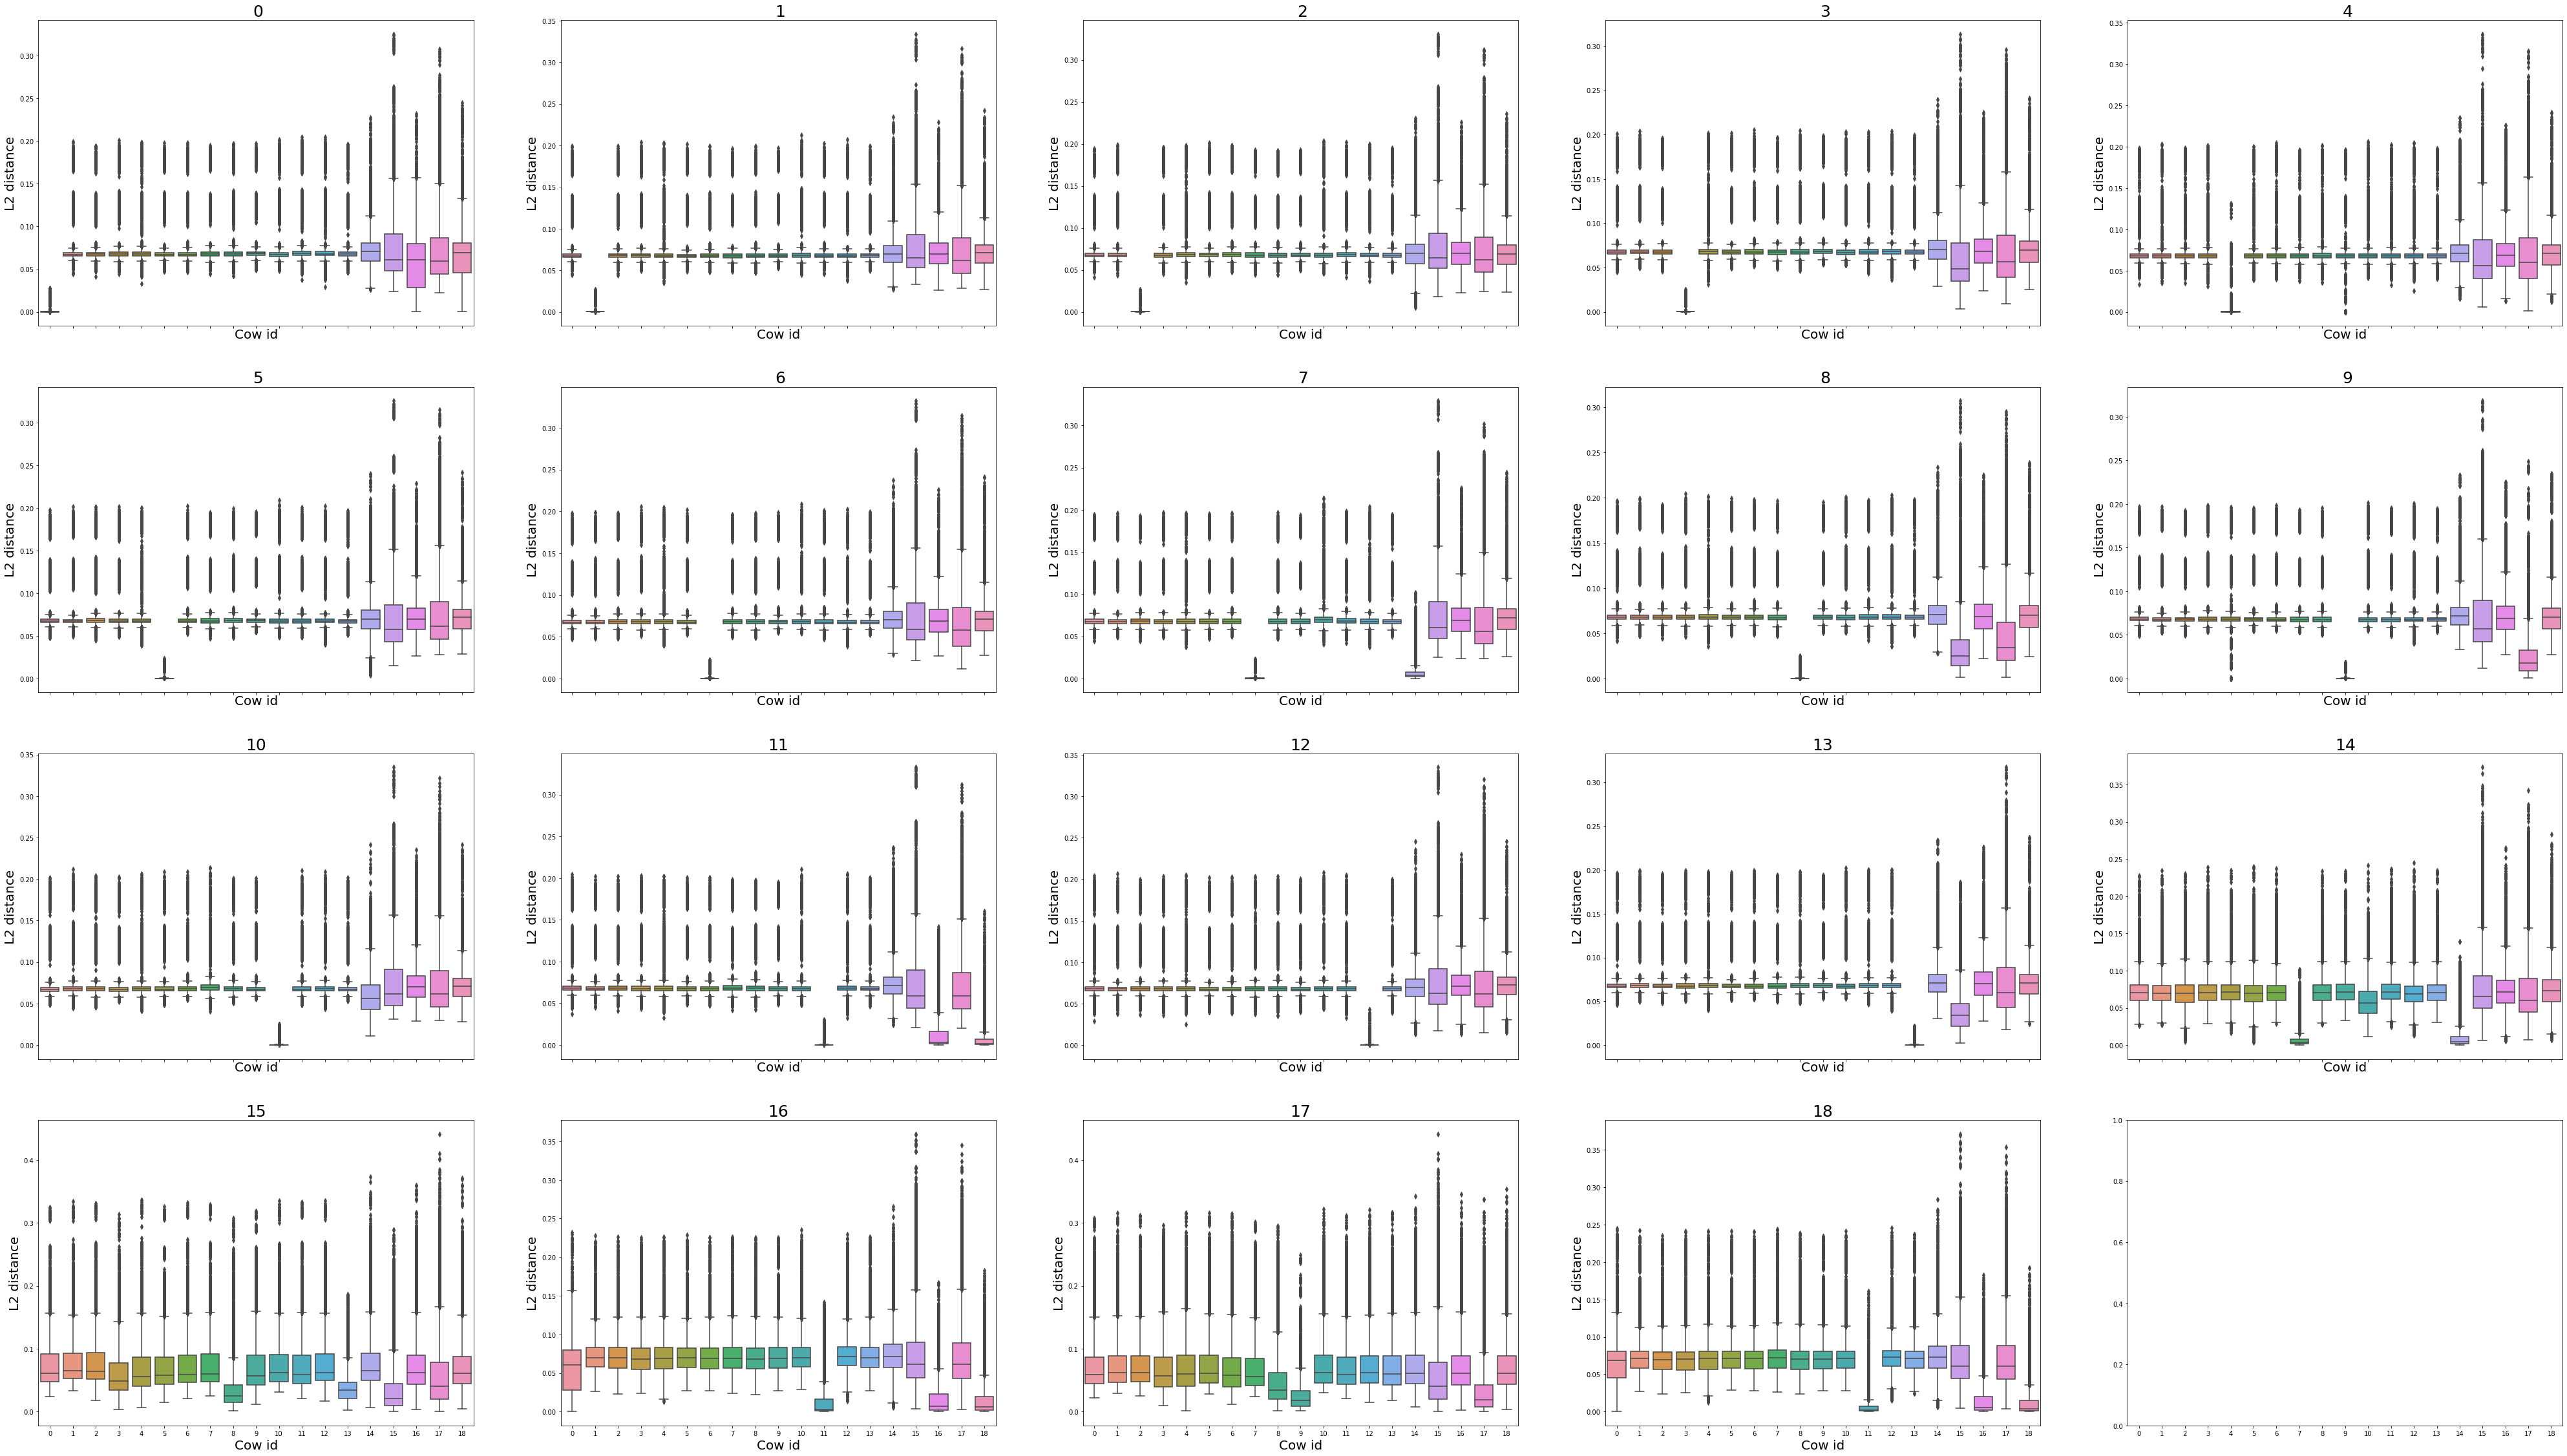

In [4]:
import seaborn as sns
fig, axes = plt.subplots(4, 5, figsize=(70, 40), sharex=True)
label = list(range(19))
for num in tqdm(range(19)):
    x = X[300*num:300*(num+1)]
    d = []
    for i in [n*300 for n in range(19)]:
        x_ = X[i:(i+300)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        d.append(dists)

    # Plot distance box plot
    sns.set(style="whitegrid")
    chart = sns.boxplot(data=d, ax=axes[num//5, num%5])
    chart.axes.set_title(f'{num:2d}',fontsize=25)
    chart.set_xlabel('Cow id', fontsize=20)
    chart.set_ylabel('L2 distance', fontsize=20)
#     print(d.index(min(d)), " ", d[d.index(min(d))])

(array([0.99998889, 1.        , 0.99821431, 0.99995556, 0.99933871,
       0.99997778, 1.        , 1.        , 0.99998889, 0.99339511,
       1.        , 0.99993334, 1.        , 0.99925611]), array([1.        , 1.        , 1.        , 1.        , 0.99066667,
       1.        , 1.        , 1.        , 1.        , 0.99934444,
       1.        , 1.        , 1.        , 1.        ]), array([0.99999444, 1.        , 0.99910635, 0.99997778, 0.99498379,
       0.99998889, 1.        , 1.        , 0.99999444, 0.9963609 ,
       1.        , 0.99996667, 1.        , 0.99962792]), array([90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000,
       90000, 90000, 90000, 90000, 90000]))
0.999286507936508


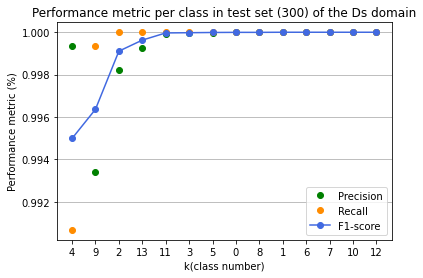

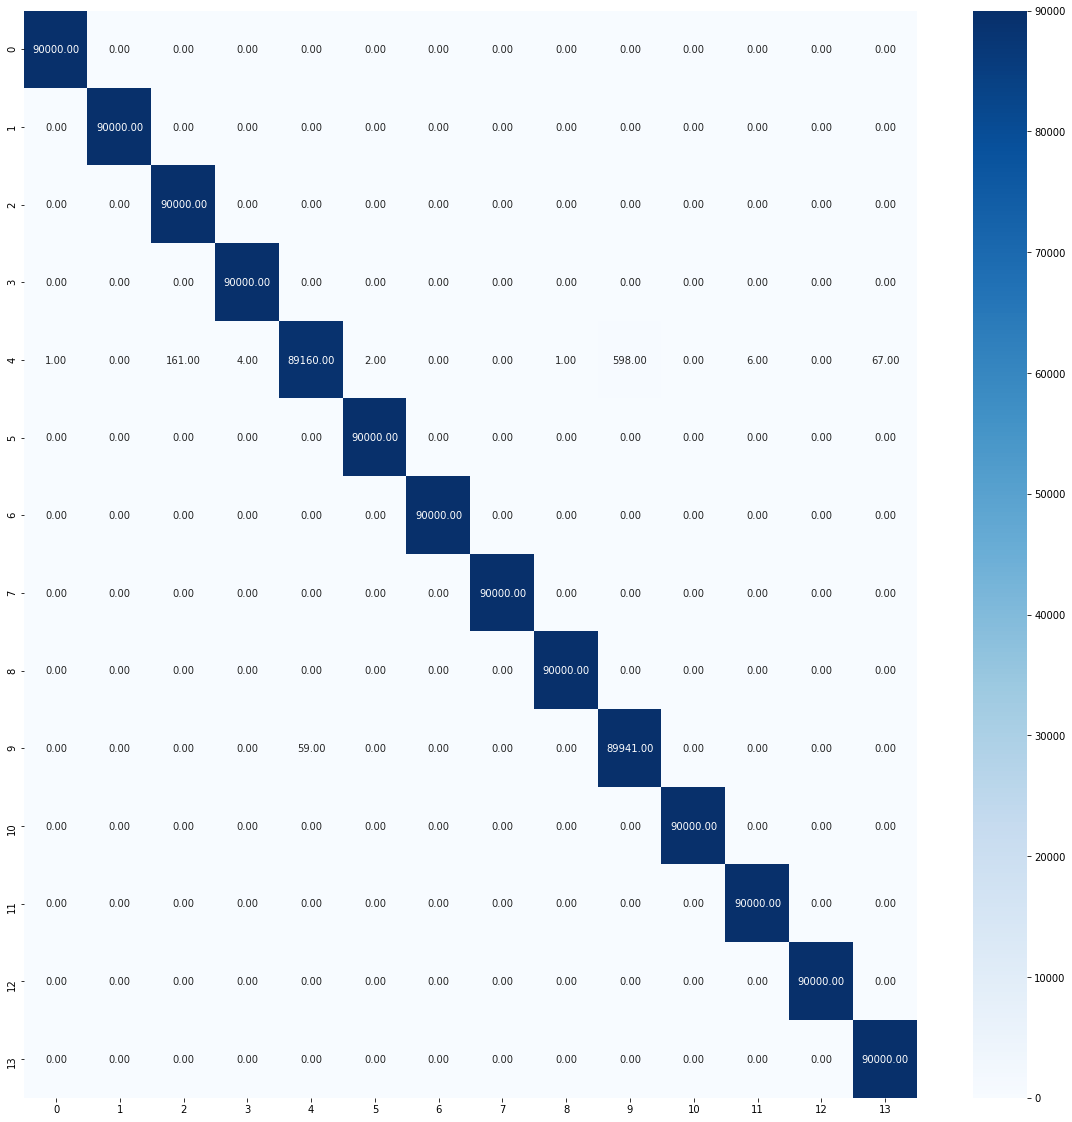

In [50]:
y_pred = np.empty((0), int)
tX_ = X[:300*14]
tX = X[:300*14]
for num in range(14):
    x = tX_[300*num:300*(num+1)]
    arr = np.empty((0,300,300), float)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(14)):
        x_ = tX[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        arr = np.append(arr, dists[np.newaxis, :], axis=0)
    y_pred = np.append(y_pred, np.argmin(arr, axis=0))
    

from sklearn.metrics import precision_recall_fscore_support

y_true = np.array([i//(300*300) for i in range(14*300*300)])
print(precision_recall_fscore_support(y_true, y_pred))
P, R, F, _ = precision_recall_fscore_support(y_true, y_pred)
label = [str(i) for i in F.argsort()]
P = P[F.argsort()]
R = R[F.argsort()]
F = F[F.argsort()]
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(label, P, 'go', label='Precision')
ax.plot(label, R, 'ro', color='darkorange', label='Recall')
ax.plot(label, F, '-bo', color='royalblue', label='F1-score')
ax.set_title('Performance metric per class in test set (300) of the Ds domain')
plt.grid(True,axis='y')
ax.set_xticks(range(len(label)))
ax.set_xticklabels(label)
plt.xlabel("k(class number)")
plt.ylabel("Performance metric (%)")
ax.legend(loc='lower right')



from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred,)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

import seaborn as sns
fig_, ax_ = plt.subplots(figsize=(20, 20))
label_font = {'size':'18'}  # Adjust to fit
ax_.set_xlabel('Predicted labels', fontdict=label_font);
ax_.set_ylabel('Observed labels', fontdict=label_font);
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues', ax=ax_)



100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


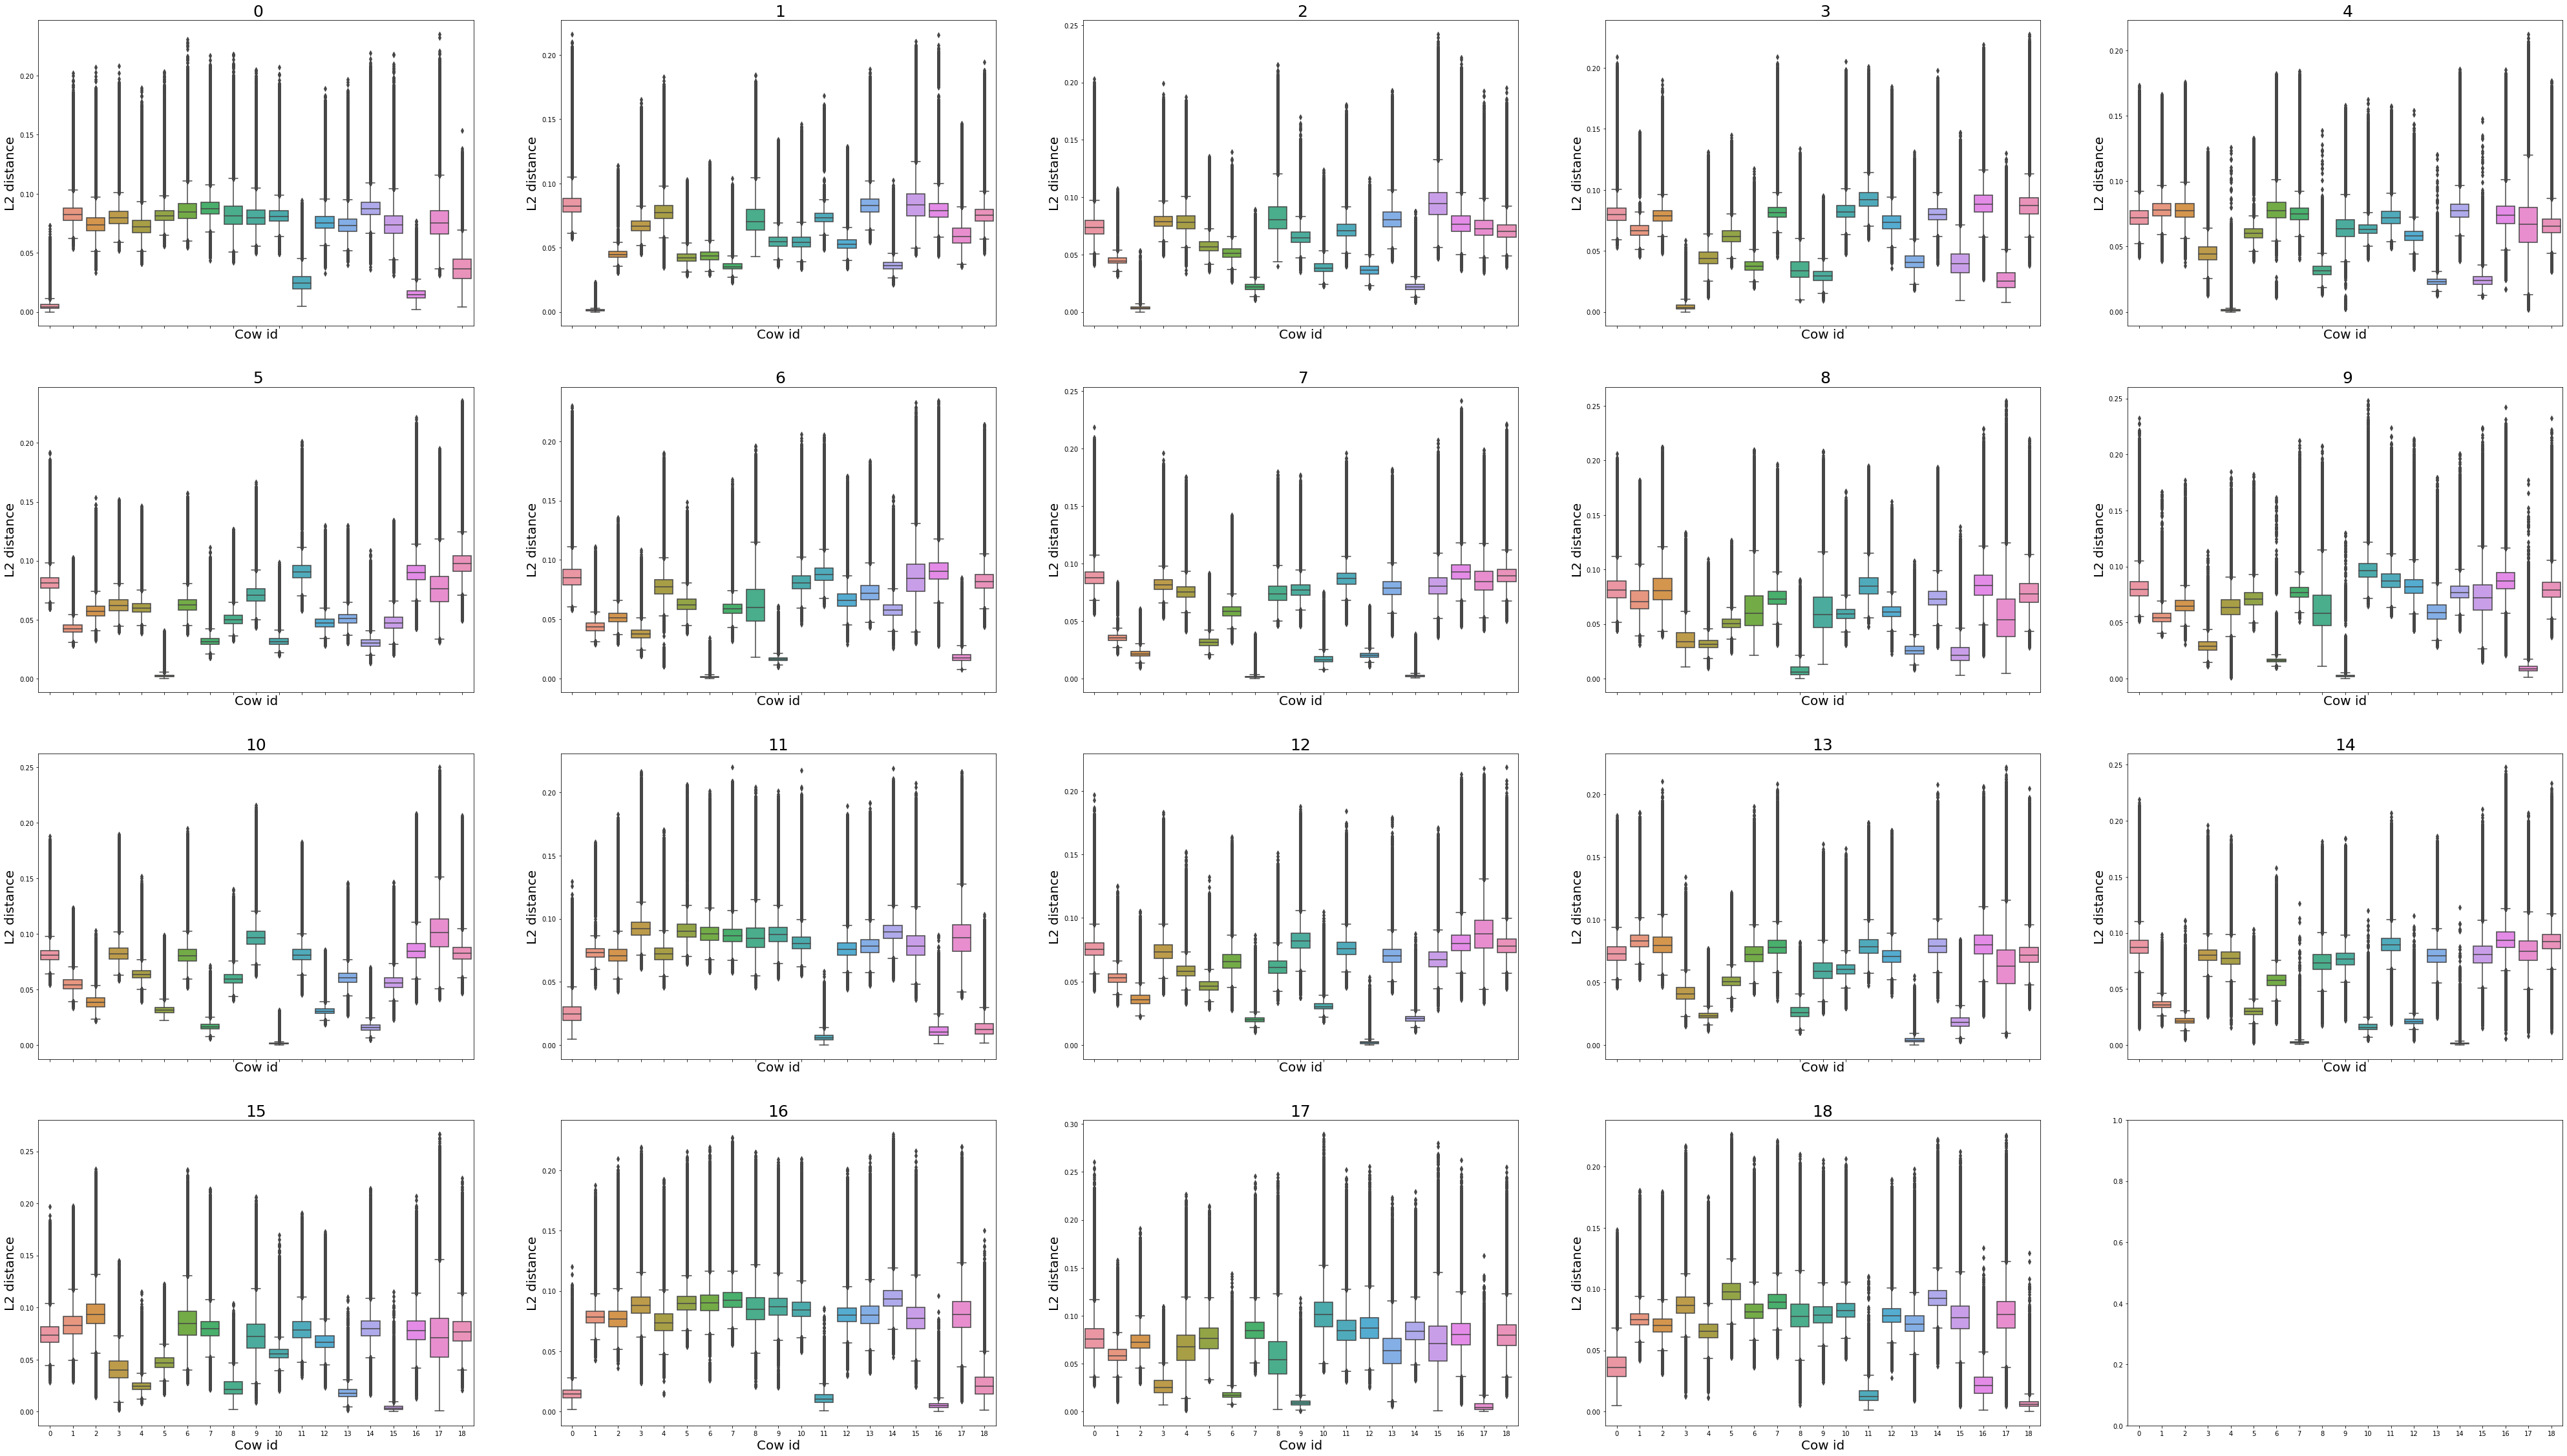

In [4]:
import seaborn as sns
fig, axes = plt.subplots(4, 5, figsize=(70, 40), sharex=True)
label = list(range(19))
for num in tqdm(range(19)):
    x = X_[2400*num:2400*(num+1)]
    d = []
    for i in [n*300 for n in range(19)]:
        x_ = X[i:(i+300)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        d.append(dists)

    # Plot distance box plot
    sns.set(style="whitegrid")
    chart = sns.boxplot(data=d, ax=axes[num//5, num%5])
    chart.axes.set_title(f'{num:2d}',fontsize=25)
    chart.set_xlabel('Cow id', fontsize=20)
    chart.set_ylabel('L2 distance', fontsize=20)
#     print(d.index(min(d)), " ", d[d.index(min(d))])

In [5]:
for num in range(19):
    x = X_[2400*num:2400*(num+1)]
    d = []
    for i in [n*300 for n in range(19)]:
        x_ = X[i:(i+300)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        d.append(np.mean(dists))
#     print(d)
    print(d.index(min(d)), d[d.index(min(d))])

0 0.005591312349689676
1 0.0018110307645156775
2 0.0039613594424216
3 0.004804660600904577
4 0.0021494614140022093
5 0.0027781944899477507
6 0.0018378146653274662
7 0.0020325764872628814
8 0.008347721100036959
9 0.002938689736336471
10 0.0018606062603640414
11 0.006802522033830198
12 0.002773468930279502
13 0.004838665696154207
14 0.0022626466146279775
15 0.004649880318156095
16 0.006196831559646787
17 0.00741318734653856
18 0.0073502325484686


In [10]:
threshold = 0.01
TA = 0
Psame = 0

for num in range(19):
    x = X_[2400*num:2400*(num+1)]
    d = []
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(19)):
        x_ = X[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        if i != num:
            fp += np.count_nonzero(dists < threshold)
            fn += (720000 - fp)
        elif i == num:
            tp += np.count_nonzero(dists < threshold)
            tn += (720000 - tp)
            
            TA += np.count_nonzero(dists < threshold)
        d.append(dists)
#         print(np.count_nonzero(dists < threshold))
#     print(f"{num} Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")
#     print(f"{num} Recall: {tp/(tp+fn)}")
    print(f"{num} Precision: {tp/(tp+fp)}")

print(TA/(2400*300*19))

0 Precision: 0.8756781187782563
1 Precision: 1.0
2 Precision: 0.9979371180647463
3 Precision: 0.9902612955285504
4 Precision: 0.9988908027977869
5 Precision: 0.9965482326951399
6 Precision: 1.0
7 Precision: 0.5407464709133317
8 Precision: 0.7726511487034217
9 Precision: 0.7694321345061798
10 Precision: 1.0
11 Precision: 0.38855762509282743
12 Precision: 1.0
13 Precision: 0.9090142390744929
14 Precision: 0.4709782191488173
15 Precision: 0.4337161968886835
16 Precision: 0.2878011950642873
17 Precision: 0.37440661595444125
18 Precision: 0.3171547579255907
0.8467171052631579


In [7]:
y_pred = np.empty((0), int)
for num in range(19):
# num = 14
    x = X_[2400*num:2400*(num+1)]
    d = []
    arr = np.empty((0,2400,300), float)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(19)):
        x_ = X[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        arr = np.append(arr, dists[np.newaxis, :], axis=0)
        if i != num:
            fp += np.count_nonzero(dists < threshold)
            fn += (720000 - fp)
        elif i == num:
            tp += np.count_nonzero(dists < threshold)
            tn += (720000 - tp)

            TA += np.count_nonzero(dists < threshold)
    y_pred = np.append(y_pred, np.argmin(arr, axis=0))
    
from sklearn.metrics import precision_score
y_true = np.array([i//(2400*300) for i in range(19*2400*300)])
print(precision_score(y_true, y_pred, average='micro'))

0.9311206871345029


## 5 class

0.9674236111111111


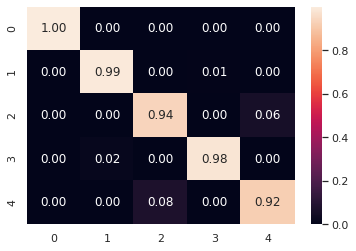

In [8]:
y_pred = np.empty((0), int)
tX_ = X_[2400*14:]
tX = X[300*14:]
for num in range(5):
    x = tX_[2400*num:2400*(num+1)]
    arr = np.empty((0,2400,300), float)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(5)):
        x_ = tX[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        arr = np.append(arr, dists[np.newaxis, :], axis=0)
    y_pred = np.append(y_pred, np.argmin(arr, axis=0))
    
from sklearn.metrics import precision_score
y_true = np.array([i//(2400*300) for i in range(5*2400*300)])
print(precision_score(y_true, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='.2f')

In [20]:
params = {
    # TODO: Modify weight each experiment
#     "weight": "./exp/0405_unDt_100/epoch-942_loss63",
#     "weight": "./exp/0315triplet_Ds14_2400_01/epoch-99",
#     "weight": "./exp/0405_unDt_1/model",
#     "weight": "./exp/0405_unDt_5/model",
#     "weight": "./exp/0405_unDt_10/model",
#     "weight": "./exp/0405_unDt_15/model",
#     "weight": "./exp/0405_unDt_20/model",
#     "weight": "./exp/0405_unDt_30/model",
#     "weight": "./exp/0405_unDt_50/model",
#     "weight": "./exp/0405_unDt_80/model",
    "weight": "./exp/0405_unDt_100/model",
    
    "D_2400": "/home/ubuntu/dataset/D_2400/",
    "Dst_300": "/home/ubuntu/dataset/DsDt_test300",
    "Dst_100": "/home/ubuntu/dataset/test_100",
    "config": {
        "num_class": 19,
        "size": [224,224],
        "batch_size": 64,
    },
}

In [38]:
logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
X = np.loadtxt(str(logdir.joinpath("vec300.tsv")), dtype=np.float, delimiter='\t')
Y = np.loadtxt(str(logdir.joinpath("meta300.tsv")), dtype=int, delimiter='\t')
# X_ = np.loadtxt(str(logdir.joinpath("vec2400.tsv")), dtype=np.float, delimiter='\t')
# Y_ = np.loadtxt(str(logdir.joinpath("meta2400.tsv")), dtype=int, delimiter='\t')

(450000,)
0.9857911111111111


Text(33.0, 0.5, 'True cow class')

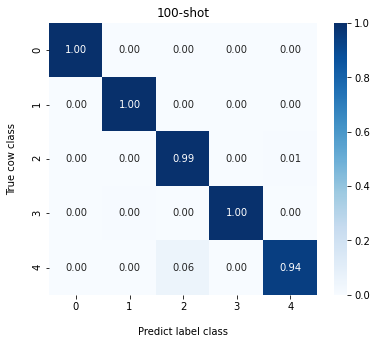

In [39]:
y_pred = np.empty((0), int)
tX_ = X[300*14:]
tX = X[300*14:]
for num in range(5):
    x = tX_[300*num:300*(num+1)]
    arr = np.empty((0,300,300), float)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(5)):
        x_ = tX[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        arr = np.append(arr, dists[np.newaxis, :], axis=0)
    y_pred = np.append(y_pred, np.argmin(arr, axis=0))
print(y_pred.shape)
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array([i//(300*300) for i in range(5*300*300)])
# print(precision_score(y_true, y_pred, average='macro'))
# print(precision_recall_fscore_support(y_true, y_pred))
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 5))
chart = sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues', ax=ax)
chart.axes.set_title("100-shot")
chart.set_xlabel('Predict label class',labelpad=15)
chart.set_ylabel('True cow class', labelpad=15)


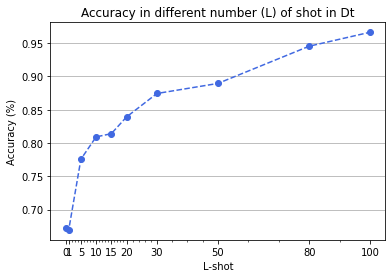

In [96]:
from matplotlib.ticker import FixedFormatter,FixedLocator
shot = [0,1,5,10,15,20,30,50,80,100]
dt_acc = [0.672793097397778,
0.6702131023203266,
0.7792645449168972,
0.8143934247458903,
0.8414250676946725,
0.8546252464539197,
0.8746267239383456,
0.8916387344189104,
0.9464370723172983,
0.9666899773945623]

dt_acc = [
    0.6722733333333333,
    0.6693311111111111,
    0.7755911111111111,
    0.8091888888888888,
    0.8140066666666667,
    0.8391711111111111,
    0.8744333333333333,
    0.8895133333333334,
    0.9454933333333333,
    0.9664955555555556
]


fig, ax = plt.subplots()
ax.plot(shot, dt_acc, '--go', color='royalblue', label='Dt (14)')

plt.grid(True,axis='y')
plt.xlabel("L-shot")
plt.ylabel("Accuracy (%)")
ax.set_title('Accuracy in different number (L) of shot in Dt')
ax.xaxis.set_major_locator(FixedLocator(shot))
ax.xaxis.set_minor_locator(FixedLocator([i for i in range(20)]+[22,24,26,28,35,40,45,60,70,90])) 
# ax.legend(loc='lower right')

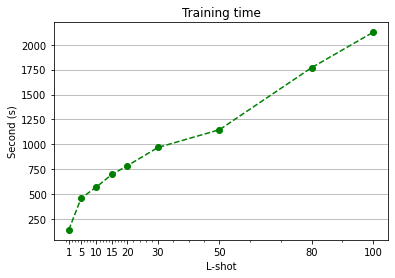

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter,FixedLocator
shot = [1,5,10,15,20,30,50,80,100]
t = [
    2125,
    1770,
    1147,
    969,
    785,
    698,
    573,
    460,
    142
]

fig, ax = plt.subplots()
ax.plot(shot, t[::-1], '--go',  label='Dt (14)')

plt.grid(True,axis='y')
plt.xlabel("L-shot")
plt.ylabel("Second (s)")
ax.set_title('Training time')
ax.xaxis.set_major_locator(FixedLocator(shot))
ax.xaxis.set_minor_locator(FixedLocator([i for i in range(20)]+[22,24,26,28,35,40,45,60,70,90])) 

(150000,)
0.9345933333333334


Text(33.0, 0.5, 'True cow class')

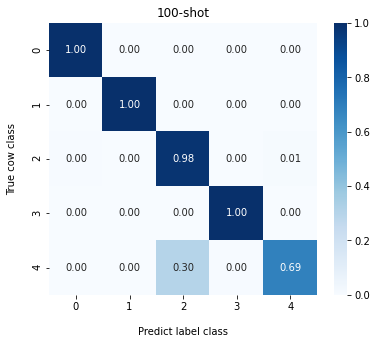

In [41]:
logdir = pathlib.Path(params['weight']).parent.joinpath('feats')
X = np.loadtxt(str(logdir.joinpath("vec100.tsv")), dtype=np.float, delimiter='\t')
Y = np.loadtxt(str(logdir.joinpath("meta100.tsv")), dtype=int, delimiter='\t')
X_ = np.loadtxt(str(logdir.joinpath("vec300.tsv")), dtype=np.float, delimiter='\t')
Y_ = np.loadtxt(str(logdir.joinpath("meta300.tsv")), dtype=int, delimiter='\t')
y_pred = np.empty((0), int)
tX_ = X[100*14:]
tX = X_[300*14:]
for num in range(5):
    x = tX_[100*num:100*(num+1)]
    arr = np.empty((0,100,300), float)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in list(range(5)):
        x_ = tX[300*i:300*(i+1)]
        dists = (-2*np.dot(x, x_.T) 
                 + np.sum(x_**2, axis=1) 
                 + np.sum(x**2, axis=1)[:, np.newaxis])
        arr = np.append(arr, dists[np.newaxis, :], axis=0)
    y_pred = np.append(y_pred, np.argmin(arr, axis=0))
print(y_pred.shape)
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array([i//(100*300) for i in range(5*100*300)])
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 5))
chart = sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues', ax=ax)
chart.axes.set_title("100-shot")
chart.set_xlabel('Predict label class',labelpad=15)
chart.set_ylabel('True cow class', labelpad=15)


In [9]:
a = [1,1,3,4,5,5,5]
count = len(a)-1
for i in a[::-1]:
    if count == 0:
        print(len(a), a)
        break
    if a[count] == a[count-1]:
        a.pop(i)
    count -= 1

4 [1, 3, 4, 5]


In [11]:
a = "aab"
ad = dict()
for i in a:
    if i not in ad:
        ad[i] = 1
    elif i in ad:
        ad[i] += 1
print(ad)

{'a': 2, 'b': 1}
